In [1]:
import os

from google.colab import drive
drive.mount('/content/gdrive')

os.chdir('/content/gdrive/MyDrive/first_try_of_fastai')

print("------------------------------------------------------------------")

Mounted at /content/gdrive
------------------------------------------------------------------


In [2]:
#export
import os
os.chdir('/content/gdrive/MyDrive/first_try_of_fastai/exp')
from nb_07a import *
os.chdir('/content/gdrive/MyDrive/first_try_of_fastai')

In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [4]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

PosixPath('/root/.fastai/data/imagenette2-160')

In [5]:
#export
import PIL,os,mimetypes
Path.ls = lambda x: list(x.iterdir())

In [6]:
path.ls()

[PosixPath('/root/.fastai/data/imagenette2-160/val'),
 PosixPath('/root/.fastai/data/imagenette2-160/.DS_Store'),
 PosixPath('/root/.fastai/data/imagenette2-160/train'),
 PosixPath('/root/.fastai/data/imagenette2-160/noisy_imagenette.csv')]

In [7]:
(path/'val').ls

<bound method <lambda> of PosixPath('/root/.fastai/data/imagenette2-160/val')>

In [8]:
path_tench = path/'val'/'n01440764'

In [9]:
img_fn = path_tench.ls()[0]
img_fn

PosixPath('/root/.fastai/data/imagenette2-160/val/n01440764/n01440764_2742.JPEG')

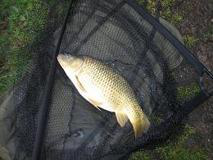

In [10]:
img = PIL.Image.open(img_fn)
img

In [11]:
import numpy
imga = numpy.array(img)

In [12]:
imga.shape

(160, 213, 3)

In [13]:
imga[:10,:10,0]

array([[38, 38, 46, 59, ..., 53, 57, 56, 45],
       [34, 38, 47, 57, ..., 62, 66, 57, 54],
       [47, 51, 52, 49, ..., 49, 44, 42, 54],
       [37, 42, 41, 39, ..., 59, 51, 35, 49],
       ...,
       [42, 46, 51, 55, ..., 39, 42, 31, 47],
       [40, 47, 59, 60, ..., 23, 35, 36, 58],
       [52, 60, 59, 45, ..., 41, 45, 45, 41],
       [50, 54, 56, 53, ..., 58, 59, 59, 47]], dtype=uint8)

In [14]:
#export
image_extensions = set(k for k,v in mimetypes.types_map.items() if v.startswith('image/') )

In [15]:
''.join(image_extensions)

'.rgb.art.pbm.djv.tiff.pnm.xwd.nef.psd.xbm.pgm.erf.svg.ppm.pcx.pat.cdt.xpm.jpx.jp2.jng.jpe.bmp.ico.crw.jpg2.ras.djvu.jpf.jpg.gif.cpt.cdr.orf.tif.jpeg.svgz.png.jpm.ief.wbmp.cr2'

In [16]:
#export
def setify(o): return o if isinstance(o,set) else set(listify(o))

In [17]:
#test_eq(setify('aa'), {'aa'})
#test_eq(setify(['aa',1]), {'aa',1})
#test_eq(setify(None), set())
#test_eq(setify(1), {1})
#test_eq(setify({1}), {1})

In [18]:
#export
def _get_files(p, fs, extensions=None):
  p = Path(p)
  res = [p/f for f in fs if not f.startswith('.')
          and ((not extensions) or f'.{f.split(".")[-1].lower()}' in  extensions)]
  return res

In [19]:
t = [o.name for o in os.scandir(path_tench)]
t = _get_files(path, t, extensions=image_extensions)
t[:3]

[PosixPath('/root/.fastai/data/imagenette2-160/n01440764_2742.JPEG'),
 PosixPath('/root/.fastai/data/imagenette2-160/n01440764_9962.JPEG'),
 PosixPath('/root/.fastai/data/imagenette2-160/n01440764_6130.JPEG')]

In [20]:
#export
def get_files(path, extensions=None, recurse=False, include=None):
  path = Path(path)
  extensions = setify(extensions)
  extensions = {e.lower() for e in extensions}
  if recurse:
    res = []
    for p,d,f in os.walk(path):
      if include is not None: d[:] = [o for o in d if o in include]
      else:                   d[:] = [o for o in d if not o.startswith('.')]
      res += _get_files(p,f,extensions)
    return res
  else:
    f = [o.name for o in os.scandir(path) if o.is_file()]
    return _get_files(path, f, extensions)

In [21]:
get_files(path_tench, image_extensions)[:5]

[PosixPath('/root/.fastai/data/imagenette2-160/val/n01440764/n01440764_2742.JPEG'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n01440764/n01440764_9962.JPEG'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n01440764/n01440764_6130.JPEG'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n01440764/n01440764_10482.JPEG'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n01440764/n01440764_11590.JPEG')]

In [22]:
get_files(path, image_extensions, recurse=True)[:3]

[PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_9431.JPEG'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_12072.JPEG'),
 PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_21472.JPEG')]

In [23]:
all_fns = get_files(path, image_extensions, recurse=True)
len(all_fns)

13394

In [24]:
%timeit -n 10 get_files(path, image_extensions, recurse=True)

10 loops, best of 5: 68.5 ms per loop


**Prepare the model**

In [25]:
#export
def compose(x, funcs, *args, order_key="_order", **kwargs):
  key = lambda o: getattr(o, order_key, 0)
  for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
  return x

class ItemList(ListContainer):
  def __init__(self, items, path='.', tfms=None):
    super().__init__(items)
    self.path, self.tfms = Path(path), tfms

  def __repr__(self): return f'{super().__repr__()}\nPath: {self.path}'
  def new(self, items): return self.__class__(items, self.path, tfms = self.tfms)

  def get(self, i): return i
  def _get(self, i): return compose(self.get(i), self.tfms)

  def __getitem__(self, idx):
    res = super().__getitem__(idx)
    if isinstance(res, list): return [self._get(o) for o in res]
    return self._get(res)

class ImageList(ItemList):
  @classmethod
  def from_files(cls, path, extensions = None, recurse=True, include=None, **kwargs):
    if extensions is None: extensions = image_extensions
    return cls(get_files(path, extensions, recurse=recurse, include = include), path, **kwargs)

  def get(self, fn): return PIL.Image.open(fn)

In [26]:
#export
class Transform(): _order=0

class MakeRGB(Transform):
  def __call__(self, item): return item.convert('RGB')

def make_rgb(item): return item.convert('RGB')

In [27]:
il = ImageList.from_files(path, tfms=make_rgb)

In [28]:
il


ImageList (13394 items)
[PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_9431.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_12072.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_21472.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_3200.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/ILSVRC2012_val_00035751.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_5772.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_20362.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_3260.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_2642.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_27582.JPEG'), ...]
Path: /root/.fastai/data/imagenette2-160

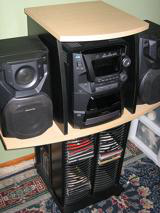

In [29]:
img = il[0];img

**split validation set**

In [30]:
fn = il.items[0];fn

PosixPath('/root/.fastai/data/imagenette2-160/val/n02979186/n02979186_9431.JPEG')

In [31]:
fn.parent.parent.name

'val'

In [32]:
#export
def grandparent_splitter(fn, valid_name = 'valid', train_name="train"):
  gp = fn.parent.parent.name
  return True if gp==valid_name else False if gp==train_name else None

def split_by_func(ds, f):
  items = ds.items
  mask = [f(o) for o in items]

  train = [o for o,m in zip(items, mask) if m==False]
  valid = [o for o,m in zip(items, mask) if m==True]
  return train, valid

In [33]:
splitter = partial(grandparent_splitter, valid_name='val')

In [34]:
%time train, valid = split_by_func(il, splitter)

CPU times: user 36.6 ms, sys: 0 ns, total: 36.6 ms
Wall time: 36.7 ms


In [35]:
len(train), len(valid)

(9469, 3925)

In [36]:
#export
class SplitData():
  def __init__(self, train, valid): self.train, self.valid = train, valid

  def __getattr__(self,k): return getattr(self.train,k)

  @classmethod
  def split_by_func(cls, il, f):
    lists = map(il.new, split_by_func(il, f))
    return cls(*lists)

  def __repr__(self): return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

In [37]:
sd = SplitData.split_by_func(il, splitter)
sd

SplitData
Train: ImageList (9469 items)
[PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_966.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_2105.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_12266.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_3525.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_19433.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_339.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_11875.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_10098.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_4646.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_3625.JPEG'), ...]
Path: /root/.fastai/data/imagenette2-160
Valid: ImageList (3925 items)
[PosixPath('/root/.fastai/data/

**Labelling**

In [38]:
#export
from collections import OrderedDict

def uniqueify(x, sort = False):
  res = list(OrderedDict.fromkeys(x).keys())
  if sort: res.sort()
  return res

In [39]:
#export
class Processor():
  def process(self, items): return items

class CategoryProcessor(Processor):
  def __init__(self): self.vocab=None

  def process(self, items):
    if self.vocab is None:
      self.vocab = uniqueify(items)
      self.otoi = {v:k for k,v in enumerate(self.vocab)}
    return [self.proc1(o) for o in items]

  def proc1(self, item): return self.otoi[item]

  def deprocess(self, idxs):
    assert self.vocab is not None
    return [self.deproc1(idx) for idx in idxs]

  def deproc1(self, idx): return self.vocab[idx]

class ProcessedItemList(ListContainer):
  def __init__(self, inputs, processor):
    self.processor = processor
    items = processor.process(inputs)
    super().__init__(items)

  def obj(self, idx):
    res = self[idx]
    if isinstance(res, (tuple, list, Generator)): return self.processor.deprocess(res)
    return self.processor.deproc1(idx)

In [40]:
#export
def parent_labeler(fn): return fn.parent.name

def _label_by_func(ds, f): return [f(o) for o in ds.items]

class LabeledData():
  def __init__(self, x ,y): self.x, self.y = x,y

  def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny:{self.y}\n'
  def __getitem__(self, idx): return self.x[idx], self.y[idx]
  def __len__(self): return len(self.x)
  
  @classmethod
  def _label_by_func(cls, il, f, proc=None):
    labels = _label_by_func(il, f)
    proc_labels = ProcessedItemList(labels, proc)
    return cls(il, proc_labels)

def label_by_func(sd, f):
  proc = CategoryProcessor()
  train = LabeledData._label_by_func(sd.train, f, proc)
  valid = LabeledData._label_by_func(sd.valid, f, proc)
  return SplitData(train, valid)

In [41]:
ll = label_by_func(sd, parent_labeler)

In [42]:
assert ll.train.y.processor is ll.valid.y.processor

In [43]:
ll.train.y.items[0], ll.train.y.obj(0), ll.train.y.obj(slice(2))

(0, 'n02979186', ['n02979186', 'n02979186'])

In [44]:
ll

SplitData
Train: LabeledData
x: ImageList (9469 items)
[PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_966.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_2105.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_12266.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_3525.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_19433.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_339.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_11875.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_10098.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_4646.JPEG'), PosixPath('/root/.fastai/data/imagenette2-160/train/n02979186/n02979186_3625.JPEG'), ...]
Path: /root/.fastai/data/imagenette2-160
y:ProcessedItemList (9469 items)
[0, 0, 0, 0, 

In [45]:
ll.train[0]

(<PIL.Image.Image image mode=RGB size=197x160 at 0x7FC3387B61D0>, 0)

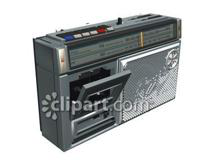

In [46]:
ll.train[0][0]

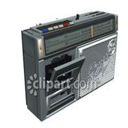

In [47]:
ll.train[0][0].resize((128,128))

In [48]:
#export
class ResizeFixed(Transform):
  _order = 10
  def __init__(self, size):
    if isinstance(size, int): size = (size, size)
    self.size = size

  def __call__(self, item): return item.resize(self.size, PIL.Image.BILINEAR)

def to_byte_tensor(item):
  res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
  w,h = item.size
  return res.view(h,w,-1).permute(2,0,1)
to_byte_tensor._order = 20

def to_float_tensor(item): return item.float().div_(255.)
to_float_tensor._order = 30

In [49]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]
il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, splitter)
ll = label_by_func(sd, parent_labeler)

In [50]:
#export
def show_image(im, figsize=(3,3)):
  plt.figure(figsize=figsize)
  plt.axis('off')
  plt.imshow(im.permute(1,2,0))

In [51]:
x,y = ll.train[0]
x.shape

torch.Size([3, 128, 128])

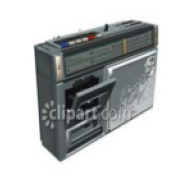

In [52]:
show_image(x)

**MODELLING**

In [53]:
bs = 64

In [54]:
train_dl,valid_dl = get_dls(ll.train, ll.valid, bs, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [55]:
x,y = next(iter(train_dl))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [56]:
x.shape

torch.Size([64, 3, 128, 128])

'n02102040'

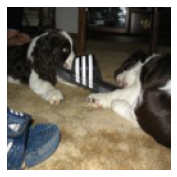

In [57]:
show_image(x[0])
ll.train.y.processor.vocab[y[0]]

In [58]:
y

tensor([8, 0, 3, 9, 1, 1, 7, 9, 9, 3, 4, 6, 8, 5, 9, 6, 1, 9, 8, 2, 8, 8, 8, 0,
        6, 6, 1, 1, 1, 4, 3, 4, 4, 5, 7, 9, 6, 5, 3, 9, 4, 7, 4, 8, 4, 3, 8, 8,
        4, 5, 6, 2, 1, 3, 9, 6, 3, 7, 5, 8, 2, 6, 5, 0])

In [59]:
#export
class DataBunch():
  def __init__(self, train_dl, valid_dl, c_in = None, c_out=None):
    self.train_dl, self.valid_dl, self.c_in, self.c_out = train_dl,valid_dl,c_in,c_out

  @property
  def train_ds(self): return self.train_dl.dataset

  @property
  def valid_ds(self): return self.valid_dl.dataset

In [60]:
#export
def databunchify(sd, bs, c_in=None, c_out=None, **kwargs):
  dls = get_dls(sd.train, sd.valid, bs, **kwargs)
  return DataBunch(*dls, c_in=c_in, c_out=c_out)

SplitData.to_databunch = databunchify

In [61]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
tfms = [make_rgb,ResizeFixed(128,),to_byte_tensor, to_float_tensor]

il = ImageList.from_files(path, tfms=tfms)
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name='val'))
ll = label_by_func(sd, parent_labeler)
data = ll.to_databunch(bs, c_in = 3, c_out=10, num_workers = 4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [62]:
cbfs = [partial(AvgStatsCallback, accuracy),
        CudaCallback]

In [63]:
m,s = x.mean((0,2,3)).cuda(), x.std((0,2,3)).cuda()
m,s

(tensor([0.4360, 0.4418, 0.4079], device='cuda:0'),
 tensor([0.2758, 0.2740, 0.2915], device='cuda:0'))

In [64]:
#export
def normalize_chan(x, mean, std):
  return (x-mean[...,None,None]) / std[...,None,None]

_m = tensor([0.47, 0.48, 0.45])
_s = tensor([0.29, 0.28, 0.30])

norm_imagenette = partial(normalize_chan, mean= _m.cuda(), std=_s.cuda())

In [65]:
cbfs.append(partial(BatchTransformXCallback, norm_imagenette))

In [66]:
nfs = [64,64,128,256]

In [75]:
#export
import math
def prev_pow_2(x): 2**math.floor(math.log2(x))

def get_cnn_layers(data, nfs, layer, **kwargs):
  def f(ni,nf,stride=2): return layer(ni, nf,3,stride=stride, **kwargs)
  print(data.c_in)
  l1 = data.c_in
  l2 = prev_pow_2(l1*3*3)
  layers = [f(l1 , l2 , stride=1 ),
            f(l2 , l2*2 , stride=2),
            f(l2*2, l2*4 , stride=2)]
  nfs = [l2*4] + nfs
  layers += [f(nfs[i], nfs[i+1]) for i in range(len(nfs)-1)]
  layers += [nn.AdaptiveAvgPool2d(1), Lambda(flatten),
             nn.Linear(nfs[-1], data.c_out)]
  return layers

def get_cnn_model(data, nfs, layer, **kwargs):
  return nn.Sequential(*get_cnn_layers(data,nfs,layer,**kwargs))

def get_learn_run(nfs, data, lr, layer, cbs=None,opt_func=None, **kwargs):
  model = get_cnn_model(data, nfs, layer, **kwargs)
  init_cnn(model)
  return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [76]:
#sched = combine_scheds([0.3,0.7], cos_1cycle_anneal(0.1,0.3,0.05))
#sched = combine_scheds([0.3,0.7], [sched_cos(0.1,0.3),sched_cos(0.3,0.05)])
sched = combine_scheds([0.3,0.7], [sched_lin(0.6,2.), sched_lin(2.,0.1)])

In [77]:
learn, run = get_learn_run(nfs, data, 0.2, conv_layer, cbs=cbfs+[
                                                                 partial(ParamScheduler,'lr', sched)
])

3


TypeError: ignored

In [78]:
#export
def model_summary(run, learn, find_all=False):
  xb,yb = get_batch(data.valid_dl, run)
  device = next(learn.model.parameters()).device
  xb,yb = xb.to(device),yb.to(device)
  mods = find_modules(learn.model, is_lin_layer) if find_all else learn.model.children()
  f = lambda hook,mod,inp,out: print(f'{mod}\n{out.shape}\n')
  with Hooks(mods, f) as hooks: learn.model(xb)

In [79]:
model_summary(run, learn)

NameError: ignored

In [ ]:
run.fit(2, learn)

In [81]:
!pip install fire

In [82]:
!python notebook2script.py 08_data_block.ipynb

Converted 08_data_block.ipynb to exp/nb_08.py
